In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten,Subtract, Lambda, Concatenate
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
SIZE = 200
BATCH_SIZE = 16
EPOCHS = 10

# Create Folder Structure

In [14]:
POS_TRAIN_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/positive/train')
POS_TEST_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/positive/test')
NEG_TRAIN_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/negative/train')
NEG_TEST_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/negative/test')
ANC_TRAIN_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/anchor/train')
ANC_TEST_PATH = os.path.join('/content/drive/MyDrive/log_id_project/data/final_gray_data/anchor/test')

In [15]:
def get_class_file_paths(path):
    classes = os.listdir(path)
    file_paths = {}
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        file_paths[class_name] = tf.data.Dataset.list_files(class_path + '/*.jpg')
    return file_paths

In [16]:
anchor_train = get_class_file_paths(ANC_TRAIN_PATH)
positive_train = get_class_file_paths(POS_TRAIN_PATH)
negative_train = get_class_file_paths(NEG_TRAIN_PATH)

In [17]:
anchor_test = get_class_file_paths(ANC_TEST_PATH)
positive_test = get_class_file_paths(POS_TEST_PATH)
negative_test = get_class_file_paths(NEG_TEST_PATH)

# Preprocess

In [18]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (SIZE,SIZE))
    img = img / 255.0

    return img

In [19]:
def create_dataset(anchor_dict, positive_dict, negative_dict):
    positive_ds = []
    negative_ds = []

    for class_name in anchor_dict.keys():
        anc_train = anchor_dict[class_name]
        pos_train = positive_dict[class_name]
        neg_train = negative_dict[class_name]

        positives = tf.data.Dataset.zip((anc_train, pos_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(anc_train)))))
        negatives = tf.data.Dataset.zip((anc_train, neg_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anc_train)))))

        positive_ds.append(positives)
        negative_ds.append(negatives)

    positives_final = positive_ds[0]
    negatives_final = negative_ds[0]
    # print(len(positive_ds))
    # print(len(negative_ds))
    for i in range(1, len(positive_ds)):
        positives_final = positives_final.concatenate(positive_ds[i])
        negatives_final = negatives_final.concatenate(negative_ds[i])

    final_dataset = positives_final.concatenate(negatives_final)

    return final_dataset

In [20]:

train_data = create_dataset(anchor_train, positive_train, negative_train)
test_data = create_dataset(anchor_test, positive_test, negative_test)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)


In [22]:

train_data = train_data.map(preprocess_twin)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=10000)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(8)

test_data = test_data.map(preprocess_twin)
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=10000)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(8)

# Model Building

## CNN

In [37]:
def make_embedding():
    inp = Input(shape=(SIZE,SIZE,1), name='input_image')

    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 191, 191, 64)        │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 42, 42, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │     339,742,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 340,937,536 (1.27 GB)

 Trainable params: 340,937,536 (1.27 GB)

 Non-trainable params: 0 (0.00 B)

In [26]:

class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(SIZE,SIZE,1))

    validation_image = Input(name='validation_img', shape=(SIZE,SIZE,1))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model = make_siamese_model()

In [42]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 200, 200, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 200, 200, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │    340,937,536 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 340,941,633 (1.27 GB)

 Trainable params: 340,941,633 (1.27 GB)

 Non-trainable params: 0 (0.00 B)

In [43]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [44]:
opt = tf.keras.optimizers.Adam(1e-4)

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [46]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [47]:
train_acc_history = []
val_acc_history = []

def train(train_data, val_data, EPOCHS):
    global loss_history, train_acc_history, val_acc_history

    for epoch in range(1, EPOCHS + 1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(train_data))

        r = Recall()
        p = Precision()

        epoch_loss = 0.0
        num_batches = 0

        for idx, batch in enumerate(train_data):
            loss = train_step(batch)
            batch_loss = loss.numpy()
            epoch_loss += batch_loss
            num_batches += 1

            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)

            progbar.update(idx + 1)

        avg_epoch_loss = epoch_loss / num_batches
        train_acc = (r.result() + p.result()) / 2
        train_acc_history.append(train_acc.numpy())

        val_r = Recall()
        val_p = Precision()
        for val_batch in val_data:
            val_yhat = siamese_model.predict(val_batch[:2])
            val_r.update_state(val_batch[2], val_yhat)
            val_p.update_state(val_batch[2], val_yhat)

        val_acc = (val_r.result() + val_p.result()) / 2
        val_acc_history.append(val_acc.numpy())

        print(f"Loss: {avg_epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

def plot_accuracy():
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()
    plt.show()


In [48]:
train(train_data,test_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

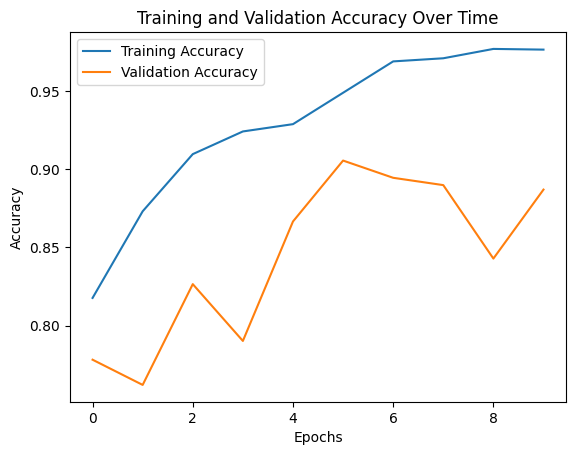

In [49]:
plot_accuracy()

In [50]:
# Save weights
siamese_model.save('/content/drive/MyDrive/log_id_project/model/siamesemodel_gray_cnn.h5')

In [51]:
# Save weights
siamese_model.save('/content/drive/MyDrive/log_id_project/model/siamesemodel_gray_cnn.keras')